
# Convolution Neural Networks


---


Link to the dataset : https://drive.google.com/file/d/14HjM98X9T2LIw7L5Io6kq0uRc9GFN93z/view?usp=sharing

---





---

# Task: Word Recognition

Training a deep CNN model that can help in recognising a word, i.e. given a word-image(image with a word present in it) as input, the model yields a representation that can help in recognising the word from a set of possible words (termed as  'lexicon' of words). 

---

## Representations of the word

There are two representations for a word:

1. **Alpha representation**: This is based on the claim that a word can be represented in terms of occurences of characters in various segments of image.

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a binary vector in which each segment correspond to alphabets/characters (Shown in fig.).

![Alpha Vector](https://drive.google.com/uc?export=view&id=17rUvYXvWUc2IP8aD-O3kualSjr2dcn2b)

*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.


*We are using levels 2-5. 
This makes the length of final Alpha vector to be (2+3+4+5) * 26 = 364*



2. **Omega representation**: This is based on the claim that a word can be represented in terms of count of **11 primitve shapes** present in various segments of image. The 11 shapes are: *ascender, descender, left small semi-circle, right small semi-circle, left large semi-circle, right large semi-circle, circle, vertical line, diagonal line, diagonal line at a slope of 135 degrees, and horizontal line*. These have been shown in figure.

![Primary Shapes](https://drive.google.com/uc?export=view&id=1573VBQwD03ae_UBjDaYk4fq84bGmDzr2)

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a vector in which each segment correspond to count of a shape.

![Omega for anagram](https://drive.google.com/uc?export=view&id=1nk1pj0yp5wunCxYeUp5ppH8hdsHF41rv)


*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.

*We are using levels 1-5. 
This makes the length of final Omega vector to be (1+2+3+4+5) * 11 = 165*

---

**Note**: For both representations, while splitting, in case of unequal lengths of segments, segments at the end should be of more length e.g. Level 3 split of "omega" = {o,me,ga} and "play" = {p,l,ay}. Also, for a smaller words like "ok" level 3 split = {$\epsilon$,o,k} where $\epsilon$ = empty string. 

---

At the end, we will detemine which representation will be more helpful for word recognition. 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import the necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cosine


In [3]:
IMG_HEIGHT = 50
IMG_WIDTH = 250
#IMGAGE_SIZE=(IMG_WIDTH,IMG_H)

# Dataset

The dataset used here is a synthetic word recognition dataset. It consists of images of lowercase English words, generated with handwritten-fonts. All images are single channel (grayscale) and have size 250 * 50. <br>

The dataset has the following directory structure:

<pre>
<b>WR-Dataset</b>
|__ <b>train</b>: [foo_1.png, bar_2.png, sample_3.png ....]
|__ <b>validation</b>: [foo_221.png, bar_322.png, sample_353.png ....]
|__ <b>test</b>: [bar_521.png, foo_272.png, example_433.png ....]
|__ <b>Alphabet.csv</b>
    
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [4]:
#Paths for train, validation and test directories
import zipfile
local_zip = '/content/drive/MyDrive/WR-Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

test_dir_path="/tmp/WR-Dataset/Test"
valid_dir_path="/tmp/WR-Dataset/Validation"
train_dir_path="/tmp/WR-Dataset/Train"

# Visualizing sample images

Preparing an image to label map and visualize 5 randomly chosen images from training, validation and test sets (along with their labels). Also, mentioning the number of word classes present in each of the three sets.




TEST DATAFRAME
Displaying data fram
            filename      label
0         game_4.png       game
1        first_6.png      first
2         when_7.png       when
3         high_6.png       high
4         days_7.png       days
..               ...        ...
395        end_6.png        end
396  following_6.png  following
397       news_5.png       news
398     county_1.png     county
399       real_5.png       real

[400 rows x 2 columns]

TEST DATAFRAME
Displaying data fram
           filename    label
0      search_1.png   search
1       pages_2.png    pages
2        like_2.png     like
3         had_7.png      had
4         who_5.png      who
...             ...      ...
2047     such_5.png     such
2048  company_0.png  company
2049     that_5.png     that
2050   online_1.png   online
2051     only_1.png     only

[2052 rows x 2 columns]

TEST DATAFRAME
Displaying data fram
           filename     label
0        read_0.png      read
1         and_0.png       and
2     special_4.pn

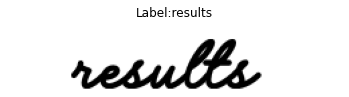

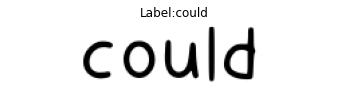

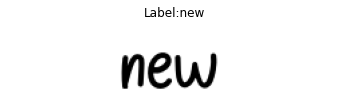

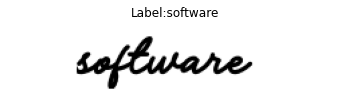

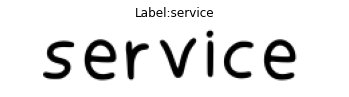


***VALIDATION DATASET IMAGES***


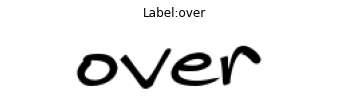

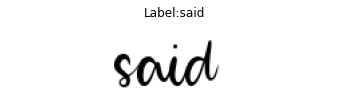

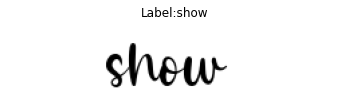

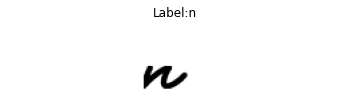

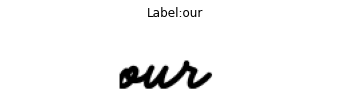


***TEST DATASET IMAGES***


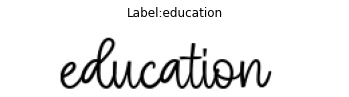

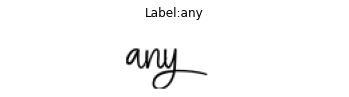

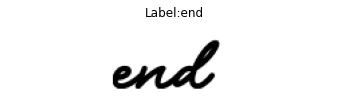

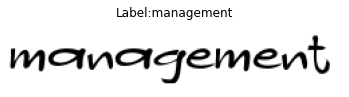

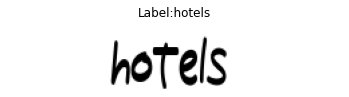

In [5]:
# Code to build a dataframe with Images and their corresponding labels for 3 folders (similar to Lab 3(a))
#import matplotlib.image as mpimg

def get_dataframe(folder_name):
    images=[]
    images_label=[]
    images_file_name=[]
    i=0
    for filename in os.listdir(folder_name):
      images_file_name.append(filename)
      temp=filename.split("_")
      images_label.append(temp[0]);
    frame_data=[]

    for i in range(len(images_label)):
      frame_data.append([images_file_name[i],images_label[i]])
    df=pd.DataFrame(frame_data,columns=['filename','label'])
    print("Displaying data fram")
    print(df)
    return df

# display the dataframes

print("\nTEST DATAFRAME")
test_df=get_dataframe(test_dir_path)
print("\nTEST DATAFRAME")
train_df=get_dataframe(train_dir_path)
print("\nTEST DATAFRAME")
valid_df=get_dataframe(valid_dir_path)


def image_visualise(temp_dir_path):
  files = os.listdir(temp_dir_path)   #test samples counting
  for i in range(5):
    index=random.randint(0,len(files)-1)
    filename=files[index]
    img = cv2.imread(os.path.join(temp_dir_path,filename))  
    plt.imshow(img)
    plt.title("Label:"+filename.split("_")[0])
    plt.axis('Off')
    plt.show()

# Visualise images from the train set
print("\n***TRAIN DATASET IMAGES***")
image_visualise(train_dir_path)


# Visualise images from the validation set
print("\n***VALIDATION DATASET IMAGES***")
image_visualise(valid_dir_path)



# Visualise images from the test set
print("\n***TEST DATASET IMAGES***")
image_visualise(test_dir_path)


In [6]:
print("--NUMBER OF WORD CLASSES--")
test_word_classes=len(test_df.label.unique())
train_word_classes=len(train_df.label.unique())
valid_word_classes=len(valid_df.label.unique())
print("No. of word classes in test dataset:",test_word_classes)
print("No. of word classes in train dataset:",train_word_classes)
print("No. of word classes in validation dataset:",valid_word_classes)

--NUMBER OF WORD CLASSES--
No. of word classes in test dataset: 198
No. of word classes in train dataset: 300
No. of word classes in validation dataset: 86


Modules that can give vector representations for the input words.

---

---

In [7]:
def get_Omega_vector(word):
  #Function that returns Omega representation of the input word
  words=[]
  for i in range(1,6):
       frm=0
       z=len(word)
       #print()
       remain=i
       for j in range(1,i+1):
           step=z//remain
           words.append(word[frm:frm+step])
           #print(word[frm:frm+step],end="\t")
           z-=step
           remain-=1
           frm=frm+step
  
  df = pd.read_csv("/tmp/WR-Dataset/Alphabet.csv",header=None)
  d=df.set_index(0).T.to_dict('list') #creating dictionary from csv file
  
  omega_vector=[]
  for word in words:
    lables=[0]*11
    if len(word)>0:
        for ch in word:
            if ch=='':
                break
            lables=[sum(x) for x in zip(d[ch.lower()],lables)]
    omega_vector+=lables
  return omega_vector    #It will return vector representation of Omega representation

In [8]:
def get_Alpha_vector(word):
  #Function that returns Alpha representation of the input word 
  words=[]
  for i in range(2,6):
      frm=0
      z=len(word)
      #print()
      remain=i
      for j in range(1,i+1):
          step=z//remain
          words.append(word[frm:frm+step])
          #print(word[frm:frm+step],end="\t")
          z-=step
          remain-=1
          frm=frm+step
  #print(words)

  #making binary string
  alpha_vector=[]
  for word in words:
      #print(word)
      lables=[0]*26
      if len(word)>0:
          for ch in word:
              if ch=='':
                  break
              lables[ord(ch.lower())-ord('a')]=1
      alpha_vector+=lables
      #alpha_vector.append(lables)
  return alpha_vector

To test the above modules, try printing Omega and Alpha vectors for your first name.

In [9]:
name ="Sanchit"

print("Omega vector:",get_Omega_vector(name))

print("Alphavector:",get_Alpha_vector(name))


Omega vector: [1, 0, 3, 0, 1, 0, 1, 6, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1]
Alphavector: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

# Building Alpha model architecture 

Following is the architecture of the model that will learn Alpha representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 364 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, except the final layer use ReLu activation.

For final layer, use sigmoid activation.

**Loss function**: Binary cross-entropy

**Similarity Metric**: Cosine Similarity

Also will be making a function that will take a learning rate as parameter as return the compiled Alpha model.


In [10]:
#Function that returns a model which will predict Alpharepresentation

def Alpha_model(learning_rate=1e-4):
    # Instantiate Sequential model
    
    model = keras.models.Sequential()
    # Add Layers
    model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(250,50,3)))
    model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
    model.add(keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    for i in range(6):
        model.add(keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu',padding="same"))
    for i in range(3):
        model.add(keras.layers.Conv2D(512,kernel_size=(3,3),activation='relu',padding="same"))
    model.add(keras.layers.GlobalAveragePooling2D())
    for i in range(2):
        model.add(keras.layers.Dense(4096,activation='relu'))
        model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(364,activation='sigmoid'))
    
    # Define optimizers(Adam Optimizers), loss function and similarity metrics
    
    ############################################
    opt = tf.keras.optimizers.Adam(learning_rate)
    cat_loss =tf.keras.losses.BinaryCrossentropy()
    acc_metrics = [tf.keras.metrics.CosineSimilarity()]
    
    # Compile the model
    model.compile(optimizer=opt, loss=cat_loss, metrics=acc_metrics)
    
    
    # return model
    return model
model=Alpha_model()
model.summary()
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 48, 64)       1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 246, 46, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 23, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 21, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 119, 19, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 9, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 9, 256)        2

Following is the architecture of the Omega model, i.e. model that will learn to predict Omega representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 165 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, use ReLu activation.

**Loss function**: Mean-squared error

**Similarity Metric**: Cosine Similarity

Also will be making a function that will take a learning rate as parameter as return the compiled Omega model.


In [11]:
#Function that returns a model which will predict Omega representation

def Omega_model(learning_rate=1e-4):
    # Instantiate Sequential model

    model = keras.models.Sequential()
    # Add Layers
    #model.add(keras.layers.Embedding(input_dim=165,output_dim=165,input_length=165)),
    model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(250,50,3)))
    model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')),
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
    model.add(keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    for i in range(6):
        model.add(keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu',padding="same"))
    for i in range(3):
        model.add(keras.layers.Conv2D(512,kernel_size=(3,3),activation='relu',padding="same"))
    model.add(keras.layers.GlobalAveragePooling2D())
    for i in range(2):
        model.add(keras.layers.Dense(4096,activation='relu'))
        model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(165,activation='relu'))
    
    # Define optimizers(Adam Optimizers), loss function and similarity metrics
    
    ############################################
    opt = tf.keras.optimizers.Adam(learning_rate)
    cat_loss =tf.keras.losses.MeanSquaredError()
    acc_metrics = [tf.keras.metrics.CosineSimilarity()]
    
    # Compile the model
    model.compile(optimizer=opt, loss=cat_loss, metrics=acc_metrics)
    
    return model

model=Omega_model()
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 248, 48, 64)       1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 246, 46, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 23, 64)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 121, 21, 128)      73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 119, 19, 128)      147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 59, 9, 128)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 59, 9, 256)       

Why did we use BCE as loss function and sigmoid as activation for final layer in Alpha model, while MSE and ReLu for Omega model?







>Alpha Model:-

Sigmoid activation is required at the output layer as we are giving a vector of any word in the form of a list of  364 binary numbers as a label for training to network. Sigmoid activation function has the property that if its calculated value is >=0.5, then it will belong to binary class ‘1’ otherwise binary class ‘0’. Thus, at the output , we will get the predicted binary number’s list that is label. If we use another activation function at the output layer, we won’t get a binary vector at the output. Thus relu can't be use.

Binary Cross Entropy 

It is used since the given problem in binary classification problem. All the output layer neurons will be predicting the binary vector. In order to reduce the binary prediction, we are considering BCE.

MSE is applicable to only normal distribution only but this problem is following normal distribution.

Also, we can’t apply MSE on classification problem as it MSE in non-convex for classification problem.

>Omega Model:-

Activation function: relu

In the given problem modeling, the input vector is not binary in fact it has frequency of the characters (as per given in prob. statement). Thus, we can’t apply binary classification sigmoid activation on it as it will lead to loss of the predicted data at the output layer.
Since the frequency of vector numbers is not in the binary form, it is best to use mean square loss .

Using BCE in place of MSE will not be helpful as it 

In terms of the probability distribution, the omega problem is following the Normal distribution and the alpha model is  following binomial distribution. Thus, with respect to the properties, MSE should be applied to the omega model and CE should be applied to classification problems that are alpha model probel.




## Seen and Unseen Words

Words whose images hase been seen by the model during training are termed as seen words, while those which are part of the test set but not seen during training are called unseen words.


In [12]:
#Code to print seen word classes 
seen_classes=train_df.label.unique()     #because classes are unique
print("--SEEN WORLD CLASSES--")  
i=1
for cls in seen_classes:
  print(i,cls)
  i+=1

#Code to print unseen word classes from test set
unseen_classes=test_df.label.unique()     #because classes are unique
print("\n--UNSEEN WORLD CLASSES--")
i=1
for cls in unseen_classes:
  print(i,cls)
  i+=1


--SEEN WORLD CLASSES--
1 search
2 pages
3 like
4 had
5 who
6 copyright
7 before
8 products
9 do
10 sports
11 security
12 community
13 that
14 number
15 high
16 privacy
17 about
18 add
19 should
20 our
21 family
22 last
23 or
24 based
25 when
26 web
27 service
28 p
29 index
30 two
31 real
32 prices
33 may
34 set
35 we
36 with
37 special
38 mail
39 development
40 general
41 ebay
42 want
43 way
44 out
45 know
46 then
47 us
48 south
49 life
50 does
51 city
52 also
53 order
54 site
55 part
56 all
57 phone
58 so
59 view
60 would
61 posted
62 how
63 info
64 day
65 own
66 i
67 top
68 technology
69 is
70 date
71 be
72 report
73 links
74 name
75 code
76 travel
77 over
78 where
79 if
80 off
81 uk
82 company
83 said
84 section
85 map
86 items
87 games
88 de
89 take
90 he
91 type
92 both
93 any
94 get
95 show
96 m
97 you
98 management
99 g
100 a
101 can
102 user
103 your
104 first
105 through
106 used
107 version
108 check
109 has
110 free
111 pm
112 please
113 under
114 been
115 even
116 same
117 

In [13]:
NUM_EPOCHS=30
BATCH_SIZE=8

# Tuning Hyperparameters for Omega Model
We will now tune the *learning rate* for the first model. 
For that, load the train and validation data (images and their labels, i.e. Omega vectors) 


In [14]:
def image_array(file,path): #it will return image array
    path=os.path.join(path,file)
    img=load_img(path,grayscale=False,color_mode='rgb',target_size=(250,50),
           interpolation='nearest')
    return tf.keras.preprocessing.image.img_to_array(img)

######## TRAIN ###########
train_images=[]
temp=train_df['filename'].to_numpy()
for i in temp:
    train_images.append(image_array(i,train_dir_path))
train_images=np.array(train_images) #train images array

train_labels=[]
temp=train_df['label'].to_numpy()
for l in temp:
  train_labels.append(get_Omega_vector(l))
train_labels=np.array(train_labels) #train labels

###### VALID ###############
valid_images=[]
temp=valid_df['filename'].to_numpy()
for i in temp:
    valid_images.append(image_array(i,valid_dir_path))

valid_images=np.array(valid_images)
#print(train_images)

valid_labels=[]
temp=valid_df['label'].to_numpy()
for l in temp:
  valid_labels.append(get_Omega_vector(l))
valid_labels=np.array(valid_labels)


Now find the best LR for the Omega model.


In [15]:
import math
TRAIN_IMAGES=train_df.count()[0]
VALID_IMAGES=valid_df.count()[0]
#print(train_images,valid_images)

def determine_Omega_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []

    for l_rate in learning_rates:
        
        # Code to build a model with the current learning rate
        model=Omega_model(learning_rate=l_rate)
        
        # Code to train the model using the training set and validate using the validation set
        history=model.fit(x=train_images,
                          y=train_labels,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=math.ceil(TRAIN_IMAGES/BATCH_SIZE),
                          validation_data=(valid_images,valid_labels),
                          validation_steps=math.ceil(VALID_IMAGES/BATCH_SIZE),
                          batch_size=BATCH_SIZE,
                          verbose=1
                          )
        
        # Code to find the average validation accuracy for this model setting and append it to the maintained list
        val_acc = history.history['val_cosine_similarity']  #It will return list of accuracy at every epochs
        avg_val=sum(val_acc)/len(val_acc)
        avg_val_similarity.append(avg_val)  #pushing average accuracy

    # Code to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    best_rate=learning_rates[avg_val_similarity.index(max(avg_val_similarity))]
    print("Best learning rate:",best_rate,
          "with accuracy (val_cosine_similarity):",max(avg_val_similarity))
    return best_rate
# determine_best_learning_rate() is being called here
best_Omega_lr = determine_Omega_lr()

Epoch 1/30
257/257 [==============================] - 75s 165ms/step - loss: 5.5860 - cosine_similarity: 0.1712 - val_loss: 0.3560 - val_cosine_similarity: 0.6220
Epoch 2/30
257/257 [==============================] - 40s 156ms/step - loss: 0.3734 - cosine_similarity: 0.6083 - val_loss: 0.3355 - val_cosine_similarity: 0.6551
Epoch 3/30
257/257 [==============================] - 40s 156ms/step - loss: 0.3481 - cosine_similarity: 0.6441 - val_loss: 0.3201 - val_cosine_similarity: 0.6785
Epoch 4/30
257/257 [==============================] - 40s 156ms/step - loss: 0.3359 - cosine_similarity: 0.6600 - val_loss: 0.3073 - val_cosine_similarity: 0.6949
Epoch 5/30
257/257 [==============================] - 40s 156ms/step - loss: 0.3165 - cosine_similarity: 0.6806 - val_loss: 0.3054 - val_cosine_similarity: 0.6989
Epoch 6/30
257/257 [==============================] - 40s 156ms/step - loss: 0.3362 - cosine_similarity: 0.6787 - val_loss: 0.3038 - val_cosine_similarity: 0.6999
Epoch 7/30
257/257 [==

# Tuning Hyperparameters for Alpha Model
We will now tune the *learning rate* for the second model. 

For that, load the train and validation data (images and their labels, i.e. Alpha vectors) 


In [16]:
#Code for loading train and validation set images and their corresponding labels 

######## TRAIN ###########
alpha_train_images=[]

temp=train_df['filename'].to_numpy()
for i in temp:
    alpha_train_images.append(image_array(i,train_dir_path))

alpha_train_images=np.array(alpha_train_images) #train images array to nparray

alpha_train_labels=[]
temp=train_df['label'].to_numpy()
for l in temp:
  alpha_train_labels.append(get_Alpha_vector(l))
alpha_train_labels=np.array(alpha_train_labels) #train labels

###### VALID ###############
alpha_valid_images=[]
temp=valid_df['filename'].to_numpy()
for i in temp:
    alpha_valid_images.append(image_array(i,valid_dir_path))

alpha_valid_images=np.array(alpha_valid_images)

alpha_valid_labels=[]
temp=valid_df['label'].to_numpy()
for l in temp:
  alpha_valid_labels.append(get_Alpha_vector(l))
alpha_valid_labels=np.array(alpha_valid_labels)


Finding the best LR for the Omega model.


In [17]:
def determine_Alpha_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []

    for l_rate in learning_rates:
        
        # Code to build a model with the current learning rate
        model=Alpha_model(learning_rate=l_rate)
        
        # Code to train the model using the training set and validate using the validation set
        history=model.fit(x=alpha_train_images,
                          y=alpha_train_labels,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=math.ceil(TRAIN_IMAGES/BATCH_SIZE),
                          validation_data=(alpha_valid_images,alpha_valid_labels),
                          validation_steps=math.ceil(VALID_IMAGES/BATCH_SIZE),
                          batch_size=BATCH_SIZE,
                          verbose=1
                          )
        
        # Code to find the average validation accuracy for this model setting and append it to the maintained list
        val_acc = history.history['val_cosine_similarity']  #It will return list of accuracy at every epochs
        avg_val=sum(val_acc)/len(val_acc)
        avg_val_similarity.append(avg_val)  #pushing average accuracy

    # Code to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    best_rate=learning_rates[avg_val_similarity.index(max(avg_val_similarity))]
    print("Best learning rate:",best_rate,
          "with accuracy (val_cosine_similarity):",max(avg_val_similarity))
    return best_rate
# determine_best_learning_rate() is being called here
best_Alpha_lr = determine_Alpha_lr()

Epoch 1/30
257/257 [==============================] - 42s 159ms/step - loss: 0.3315 - cosine_similarity: 0.2765 - val_loss: 0.1674 - val_cosine_similarity: 0.2835
Epoch 2/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1704 - cosine_similarity: 0.3059 - val_loss: 0.1656 - val_cosine_similarity: 0.2903
Epoch 3/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1696 - cosine_similarity: 0.3086 - val_loss: 0.1664 - val_cosine_similarity: 0.2929
Epoch 4/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1716 - cosine_similarity: 0.3057 - val_loss: 0.1646 - val_cosine_similarity: 0.2941
Epoch 5/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1699 - cosine_similarity: 0.3082 - val_loss: 0.1647 - val_cosine_similarity: 0.2934
Epoch 6/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1717 - cosine_similarity: 0.3095 - val_loss: 0.1643 - val_cosine_similarity: 0.2953
Epoch 7/30
257/257 [==

---

Describe the purpose and arguments of following callbacks from `tensorflow.keras.callbacks`


1. EarlyStopping()

When given matric for monitoring stops improving, then it stops the training.

Arguments:-

Monitor: Monitoring quantity

min_delta: Minimum threshold amount of change to qualify the improvement.

patience: Maximum numbers of epochs to which model can see no improvement, after it, model will stop

verbose: Verbosity mode (integer value 0,1,2)

mode: It can be "auto", "min", "max". In "min" mode, model stops training when monitored quantity stops improvement. "Max" mode will stop training if quantity monitored has stop increasing. "auto" is automatic adjusted.

baseline: It is baseline value for the quantity which is monitored. Model will stop training if it does not show improvement over the training.

restore_best_weights: Boolena type (true or false). It will decide if restore model weights from epoch with best monitored quantity.


2. ReduceLROnPlateau() 

When given metric to monitor stop improving, then reduce the learning rate by some factor.

monitor: matric need to monitor

factor: reducing factor of learning rate (factor*lr)

patience: Maximum numbers of epochs to which model can see no improvement, after it, model will stop

verbose: Verbosity mode (integer value 0,1,2)


mode: It can be "auto", "min", "max". In "min" mode, learning rate will reduced when quantity monitored stops decreasing. Monitored quantity stops increasing when then learning rate will be reduces in "max" mode. In "auto" mode, direction is automatically adjusted.

min_delta: Minimum threshold amount of change measure which is elligible for significant change.

cooldown: Number of epochs that must be wait before resuming execution.

 min_lr: minimum learning reate

3. CSVLogger() 

It streams the epoch results to the CSV files.
Various arguments:

filename:- It is the path of file in the storage location. (input type is string)

seperator:- To seperate elements of teh CSV file, this string is used.

append:- Data type:Boolean. It will append data if file exist if set true. If set false, it will overwrite existing file

4. ModelCheckPoint()

Use to save keras model or model weights.

Various agruments:-

filepath:- string with contain path will be given. This is the path to save the model. filelepath may contain named formatting options. which contain epoch, logs (passed on on_epoch_end).

monitor: Monitor matric name. It is set by Model.compile method.
It have prefixes. Prefix "val_" is use to monitor validation matrix. "loss" prefix is use to monitor model's loss. Keras matrics.Metric can also be used.

verbose: Verbosity mode (integer value 0,1,2)

save_best_only:- Boolean varible. If true, it will the best and latest best model with respect to all monitored quantity. If filepath don't contain formatting option epoch, then new better model will be overwrite to filepath.

save_weights_only:- Boolean variable. If true, model's weight only will be saved, otherwise full model will be saved.

save_freq:- It can be "epoch" or integer. Callback will save the model after every epoch is "epoch" is used. In case of integer, callback will saves the model at the end of many branches. Saving must be alligned with epochs for reliablity.

options:- Optional tf.train.CheckpointOptions object if save_weights_only is true or optional tf.saved_model.SaveOptions object if save_weights_only is false.

**kwargs: For backward compatibality, these additional arguments are used.


# Model building and training using callbacks

---
Now building and summarize the Omega model as per the best learning rate value determined earlier.






In [18]:
# Code for building model using the best LR determined
new_model=Omega_model(learning_rate=best_Omega_lr)
history=new_model.fit(x=train_images,
                  y=train_labels,
                  epochs=NUM_EPOCHS,
                  steps_per_epoch=math.ceil(TRAIN_IMAGES/BATCH_SIZE),
                  validation_data=(valid_images,valid_labels),
                  validation_steps=math.ceil(VALID_IMAGES/BATCH_SIZE),
                  batch_size=BATCH_SIZE,
                  verbose=1
                  )
print("Best learning rate for omega :",best_Omega_lr)
loss=history.history['loss']
cos_sim=history.history['cosine_similarity']
val_los=history.history['val_loss']
val_cos=history.history['val_cosine_similarity']
print("Its average loss:",sum(loss)/len(loss))
print("Avg Cosine Similarity:",sum(cos_sim)/len(cos_sim))
print("Avg validation loss:",sum(val_los)/len(val_los))
print("Avg validation cosine similarity:",sum(val_cos)/len(val_cos))
 

Epoch 1/30
257/257 [==============================] - 42s 160ms/step - loss: 0.3415 - cosine_similarity: 0.6532 - val_loss: 0.2473 - val_cosine_similarity: 0.7278
Epoch 2/30
257/257 [==============================] - 41s 159ms/step - loss: 0.2829 - cosine_similarity: 0.6986 - val_loss: 0.2460 - val_cosine_similarity: 0.7291
Epoch 3/30
257/257 [==============================] - 41s 159ms/step - loss: 0.2722 - cosine_similarity: 0.7058 - val_loss: 0.2446 - val_cosine_similarity: 0.7286
Epoch 4/30
257/257 [==============================] - 41s 159ms/step - loss: 0.2595 - cosine_similarity: 0.7137 - val_loss: 0.2345 - val_cosine_similarity: 0.7319
Epoch 5/30
257/257 [==============================] - 41s 159ms/step - loss: 0.2520 - cosine_similarity: 0.7159 - val_loss: 0.2221 - val_cosine_similarity: 0.7356
Epoch 6/30
257/257 [==============================] - 41s 159ms/step - loss: 0.2448 - cosine_similarity: 0.7180 - val_loss: 0.2322 - val_cosine_similarity: 0.7392
Epoch 7/30
257/257 [==

Now instantiate the four callbacks which have described above.


In [24]:
# EarlyStopping after validation loss has not improved for 5 epochs 
callback_earlystop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
callback_reducelr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3)

# CSVlogger for keeping logs in filename of your choice
omega_log_path="/tmp/WR-Dataset/Omegalogs.csv"
callback_csvlogger=keras.callbacks.CSVLogger(filename=omega_log_path)

omega_model_path="/tmp/WR-Dataset/omega.ckpt"

# ModelCheckpoint that saves the best weights of model after every 10 epochs
callback_ModelCheck=keras.callbacks.ModelCheckpoint(filepath=omega_model_path,
                                                    monitor='val_cosine_similarity',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    save_freq=10,
                                                    mode='auto'
                                                    )

# Make a list of all the callbacks
callback_list=[callback_earlystop,callback_reducelr,callback_csvlogger,callback_ModelCheck]


Now train the model using these callbacks for the loaded training word images.


Epoch 1/30
257/257 [==============================] - 42s 160ms/step - loss: 0.3369 - cosine_similarity: 0.6538 - val_loss: 0.2823 - val_cosine_similarity: 0.7282
Epoch 2/30
257/257 [==============================] - 41s 159ms/step - loss: 0.2859 - cosine_similarity: 0.6975 - val_loss: 0.2534 - val_cosine_similarity: 0.7309
Epoch 3/30
257/257 [==============================] - 41s 160ms/step - loss: 0.2708 - cosine_similarity: 0.7064 - val_loss: 0.2440 - val_cosine_similarity: 0.7313
Epoch 4/30
257/257 [==============================] - 41s 161ms/step - loss: 0.2599 - cosine_similarity: 0.7106 - val_loss: 0.2289 - val_cosine_similarity: 0.7360
Epoch 5/30
257/257 [==============================] - 41s 161ms/step - loss: 0.2542 - cosine_similarity: 0.7105 - val_loss: 0.2229 - val_cosine_similarity: 0.7375
Epoch 6/30
257/257 [==============================] - 41s 161ms/step - loss: 0.2494 - cosine_similarity: 0.7184 - val_loss: 0.2249 - val_cosine_similarity: 0.7337
Epoch 7/30
257/257 [==

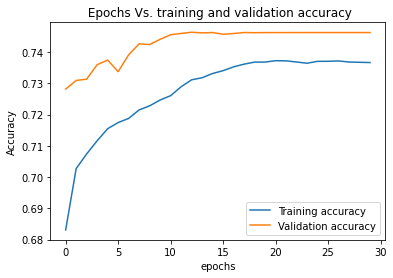

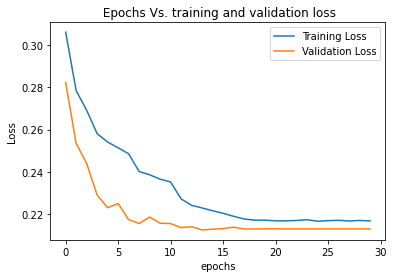

In [25]:
 # Code to train with callbacks
omega_model=Omega_model(learning_rate=best_Omega_lr)
history=omega_model.fit(x=train_images,
                  y=train_labels,
                  epochs=NUM_EPOCHS,
                  steps_per_epoch=math.ceil(TRAIN_IMAGES/BATCH_SIZE),
                  validation_data=(valid_images,valid_labels),
                  validation_steps=math.ceil(VALID_IMAGES/BATCH_SIZE),
                  batch_size=BATCH_SIZE,
                  callbacks=callback_list,
                  verbose=1
                  )


# Code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file 
callback_df=pd.read_csv(omega_log_path)
print(callback_df)

omega_epocs=callback_df['epoch'].to_numpy()
omega_ts=callback_df['cosine_similarity'].to_numpy()
omega_vs=callback_df['val_cosine_similarity'].to_numpy()
omega_tl=callback_df['loss'].to_numpy()
omega_vl=callback_df['val_loss'].to_numpy()

# Code here to plot Epochs Vs. training and validation accuracy 

plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(omega_epocs,omega_ts,label="Training accuracy")
plt.title(" Epochs Vs. training and validation accuracy")
plt.plot(omega_epocs,omega_vs,label="Validation accuracy")
plt.legend()
plt.show()


# Code here to plot Epochs Vs. training and validation loss 

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot(omega_epocs,omega_tl,label="Training Loss")
plt.title(" Epochs Vs. training and validation loss")
plt.plot(omega_epocs,omega_vl,label="Validation Loss")
plt.legend()
plt.show()

Now building and summarizing the Alpha model as per the best learning rate value determined earlier. 


In [30]:
# Code for building model using the best LR for Alpha model determined
new_model=Alpha_model(learning_rate=best_Omega_lr)
history=new_model.fit(x=alpha_train_images,
                  y=alpha_train_labels,
                  epochs=NUM_EPOCHS,
                  steps_per_epoch=math.ceil(TRAIN_IMAGES/BATCH_SIZE),
                  validation_data=(alpha_valid_images,alpha_valid_labels),
                  validation_steps=math.ceil(VALID_IMAGES/BATCH_SIZE),
                  batch_size=BATCH_SIZE,
                  verbose=1
                  )
print("Best learning rate for Alpha :",best_Alpha_lr)
loss=history.history['loss']
cos_sim=history.history['cosine_similarity']
val_los=history.history['val_loss']
val_cos=history.history['val_cosine_similarity']
print("Its average loss:",sum(loss)/len(loss))
print("Avg Cosine Similarity:",sum(cos_sim)/len(cos_sim))
print("Avg validation loss:",sum(val_los)/len(val_los))
print("Avg validation cosine similarity:",sum(val_cos)/len(val_cos))

Epoch 1/30
257/257 [==============================] - 42s 160ms/step - loss: 0.2398 - cosine_similarity: 0.2380 - val_loss: 0.1622 - val_cosine_similarity: 0.2893
Epoch 2/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1747 - cosine_similarity: 0.2907 - val_loss: 0.1608 - val_cosine_similarity: 0.2964
Epoch 3/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1690 - cosine_similarity: 0.2914 - val_loss: 0.1635 - val_cosine_similarity: 0.2841
Epoch 4/30
257/257 [==============================] - 40s 156ms/step - loss: 0.1704 - cosine_similarity: 0.2962 - val_loss: 0.1609 - val_cosine_similarity: 0.2981
Epoch 5/30
257/257 [==============================] - 40s 157ms/step - loss: 0.1647 - cosine_similarity: 0.2996 - val_loss: 0.1595 - val_cosine_similarity: 0.2974
Epoch 6/30
257/257 [==============================] - 40s 158ms/step - loss: 0.1679 - cosine_similarity: 0.3068 - val_loss: 0.1591 - val_cosine_similarity: 0.2984
Epoch 7/30
257/257 [==

Now instantiate the four callbacks for Alpha model.


In [31]:
# EarlyStopping after validation loss has not improved for 5 epochs 
callback_earlystop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
callback_reducelr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3)

# CSVlogger for keeping logs in filename of your choice
alpha_log_path="/tmp/WR-Dataset/Alphalogs.csv"
callback_csvlogger=keras.callbacks.CSVLogger(filename=alpha_log_path)

# ModelCheckpoint that saves the best weights of model after every 10 epochs
alpha_model_path="/tmp/WR-Dataset/alpha.ckpt"
callback_ModelCheck=keras.callbacks.ModelCheckpoint(filepath=alpha_model_path,
                                                    monitor='val_cosine_similarity',
                                                    save_weights_only=True,
                                                    mode='auto',
                                                    save_best_only=True,
                                                    save_freq=10,
                                                    )
# Make a list of all the callbacks
callback_list_alpha=[callback_earlystop,callback_reducelr,callback_csvlogger,callback_ModelCheck]


Now training the model with training data using these callbacks.

Epoch 1/30
257/257 [==============================] - 42s 161ms/step - loss: 0.2335 - cosine_similarity: 0.2435 - val_loss: 0.1635 - val_cosine_similarity: 0.2936
Epoch 2/30
257/257 [==============================] - 41s 160ms/step - loss: 0.1743 - cosine_similarity: 0.2904 - val_loss: 0.1622 - val_cosine_similarity: 0.2945
Epoch 3/30
257/257 [==============================] - 41s 160ms/step - loss: 0.1708 - cosine_similarity: 0.2957 - val_loss: 0.1632 - val_cosine_similarity: 0.2992
Epoch 4/30
257/257 [==============================] - 41s 160ms/step - loss: 0.1693 - cosine_similarity: 0.2992 - val_loss: 0.1603 - val_cosine_similarity: 0.2937
Epoch 5/30
257/257 [==============================] - 41s 160ms/step - loss: 0.1679 - cosine_similarity: 0.3072 - val_loss: 0.1594 - val_cosine_similarity: 0.2980
Epoch 6/30
257/257 [==============================] - 41s 161ms/step - loss: 0.1663 - cosine_similarity: 0.3041 - val_loss: 0.1585 - val_cosine_similarity: 0.3001
Epoch 7/30
257/257 [==

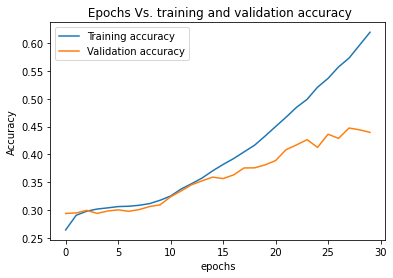

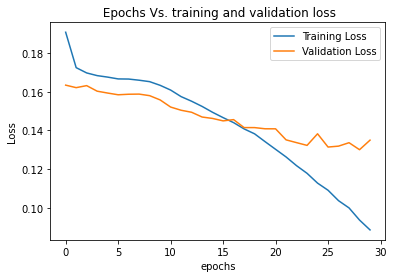

In [33]:
# Code to train with callbacks
alpha_model=Alpha_model(learning_rate=best_Omega_lr)
history=alpha_model.fit(x=alpha_train_images,
                  y=alpha_train_labels,
                  epochs=NUM_EPOCHS,
                  steps_per_epoch=math.ceil(TRAIN_IMAGES/BATCH_SIZE),
                  validation_data=(alpha_valid_images,alpha_valid_labels),
                  validation_steps=math.ceil(VALID_IMAGES/BATCH_SIZE),
                  callbacks=callback_list_alpha,
                  batch_size=BATCH_SIZE,
                  verbose=1
                  )

# Code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file
callback_df=pd.read_csv(alpha_log_path)
print(callback_df)

alpha_epocs=callback_df['epoch'].to_numpy()
alpha_ts=callback_df['cosine_similarity'].to_numpy()
alpha_vs=callback_df['val_cosine_similarity'].to_numpy()
alpha_tl=callback_df['loss'].to_numpy()
alpha_vl=callback_df['val_loss'].to_numpy()

# Code here to plot Epochs Vs. training and validation accuracy

plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(alpha_epocs,alpha_ts,label="Training accuracy")
plt.title(" Epochs Vs. training and validation accuracy")
plt.plot(alpha_epocs,alpha_vs,label="Validation accuracy")
plt.legend()
plt.show()


# Code here to plot Epochs Vs. training and validation loss

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot(alpha_epocs,alpha_tl,label="Training Loss")
plt.title(" Epochs Vs. training and validation loss")
plt.plot(alpha_epocs,alpha_vl,label="Validation Loss")
plt.legend()
plt.show()

## Steps for Word recognition:

First, prepare a list having all the words from test set mapped to their corresponding vectors (lexicon for both Omega and Alpha representations).



In [50]:
alpha_test_map={} #dictionary mapping word to its vector
omega_test_map={}
for i in range(test_df.count()[0]):
  temp=test_df['label'][i]
  alpha_test_map[temp]=get_Alpha_vector(temp)
  omega_test_map[temp]=get_Omega_vector(temp)


For every image in the test set:
1. Predict the output vector representation from the trained model(s) when the image is given as input.
2. Find the word class(from lexicon) for which the similarity of its vector representation will be highest with the output vector.
3. If predicted word = true word, then it is a correct prediction, otherwise incorrect prediction.

---

Let us now perform recognition using trained Alph amodel on the test set. 

First, load the test images and their vector representations.


In [53]:
# Code to load test images and its vector labels

test_images=[]
temp=test_df['filename'].to_numpy()
for i in temp:
    test_images.append(image_array(i,test_dir_path))
test_images=np.array(test_images)

alpha_test_labels=[]
omega_test_labels=[]
temp=test_df['label'].to_numpy()
for l in temp:
  alpha_test_labels.append(get_Alpha_vector(l))
  omega_test_labels.append(get_Omega_vector(l))

alpha_test_labels=np.array(alpha_test_labels)
omega_test_labels=np.array(omega_test_labels)

In [54]:
########CREATING DICTIONARY--JUST SOME UTILITY FUNCTIONS  ########
from scipy.spatial.distance import cosine

def return_similar(vec,tlab): #use to find the cosine distance between the vectors and return the one similar to that.
  temp=[]
  for i in range(len(tlab)):
    val=cosine(vec,tlab[i])
    if val==0:
      return tlab[i]
    temp.append(val) #cosine distance
  #print(min(temp))
  index=temp.index(min(temp))
  return tlab[index]

def make_str(s): #convert list to string (without any whitespaces)
  st=""
  for ch in s:
    st+=str(ch)
  return st

alpha_dic={}
omega_dic={}

for i in range(test_df.count()[0]):
  temp=test_df['label'][i]
  alpha_dic[make_str(alpha_test_labels[i])]=temp
  omega_dic[make_str(omega_test_labels[i])]=temp

  #omega_test_map[temp]=get_Omega_vector(temp)

Now load the saved trained Alpha model from the file and predict the labels


In [59]:
# Loading the saved model from file

alpha_model.load_weights(alpha_model_path)                  #loading alpha_model_path file weights


In [55]:
# Predicting word labels of the test set images 
pridict=alpha_model.predict(x=test_images,batch_size=16)
#print(pridict)

for i in range(len(pridict)):
  x=return_similar(pridict[i],alpha_test_labels)
  print("Pridicted:",alpha_dic[make_str(x)],"\tOriginal:",test_df['label'][i]) #calling above customize functions

Pridicted: power 	Original: game
Pridicted: states 	Original: first
Pridicted: over 	Original: when
Pridicted: f 	Original: high
Pridicted: good 	Original: days
Pridicted: need 	Original: total
Pridicted: available 	Original: available
Pridicted: rights 	Original: rights
Pridicted: reviews 	Original: american
Pridicted: details 	Original: total
Pridicted: were 	Original: those
Pridicted: under 	Original: order
Pridicted: than 	Original: them
Pridicted: d 	Original: end
Pridicted: prices 	Original: phone
Pridicted: education 	Original: download
Pridicted: home 	Original: house
Pridicted: review 	Original: services
Pridicted: they 	Original: they
Pridicted: them 	Original: for
Pridicted: as 	Original: she
Pridicted: management 	Original: development
Pridicted: black 	Original: black
Pridicted: south 	Original: south
Pridicted: reviews 	Original: reviews
Pridicted: care 	Original: use
Pridicted: details 	Original: download
Pridicted: technology 	Original: following
Pridicted: prices 	Orig

Let us evaluate the performance of the model. The effective accuracy of model is defined as harmonic mean(HM) of accuracy with seen class images and accuracy with unseen class images.


In [56]:
# Code to compute accuracy of images that belong to seen classes 
print("Alpha Model")
seen_score=alpha_model.evaluate(x=train_images,y=alpha_train_labels,
                                batch_size=BATCH_SIZE)
print("Accuracy of images on seen classes:",seen_score[1])



# Code to compute accuracy of images that belong to unseen classes

unseen_score=alpha_model.evaluate(x=test_images,y=alpha_test_labels,
                           batch_size=BATCH_SIZE)

print("Accuracy of images on unseen classes(test dataset):",unseen_score[1])

# Code to compute effective accuracy

hm=2*(seen_score[1]*unseen_score[1])/(seen_score[1]+unseen_score[1])
print("Harmonic mean:",hm)

Alpha Model
257/257 [==============================] - 15s 59ms/step - loss: 0.0764 - cosine_similarity: 0.6724
Accuracy of images on seen classes: 0.6724063158035278
50/50 [==============================] - 3s 57ms/step - loss: 0.1578 - cosine_similarity: 0.4734
Accuracy of images on unseen classes(test dataset): 0.473428338766098
Harmonic mean: 0.555640735418782


Let us now perform recognition using trained Alpha model on the test set.
 
First, load the test images and their Omega vector representations.


In [ ]:
# Code to load test images and its vector labels

#images already loaded to variable (test_images), so not repeating step

#loading alpha_test_labels with alpha vectorl labels

alpha_test_labels=[]
temp=test_df['label'].to_numpy()
for l in temp:
  alpha_test_labels.append(get_Alpha_vector(l))
alpha_test_labels=np.array(alpha_test_labels)

Now loading the saveding trained Omega model from the file and predict the labels


In [60]:
# Loading the saved model from file

omega_model.load_weights(omega_model_path) #loading alpha_model_path file weights


In [57]:
# Predicting word labels of the test set images 

pridict=omega_model.predict(x=test_images,batch_size=16)

for i in range(len(pridict)):
  x=return_similar(pridict[i],omega_test_labels)
  print("Pridicted:",omega_dic[make_str(x)],"\tOriginal:",test_df['label'][i])

Pridicted: national 	Original: game
Pridicted: education 	Original: first
Pridicted: available 	Original: when
Pridicted: development 	Original: high
Pridicted: education 	Original: days
Pridicted: education 	Original: total
Pridicted: national 	Original: available
Pridicted: national 	Original: rights
Pridicted: education 	Original: american
Pridicted: education 	Original: total
Pridicted: education 	Original: those
Pridicted: education 	Original: order
Pridicted: national 	Original: them
Pridicted: education 	Original: end
Pridicted: education 	Original: phone
Pridicted: national 	Original: download
Pridicted: education 	Original: house
Pridicted: education 	Original: services
Pridicted: education 	Original: they
Pridicted: development 	Original: for
Pridicted: development 	Original: she
Pridicted: national 	Original: development
Pridicted: education 	Original: black
Pridicted: education 	Original: south
Pridicted: national 	Original: reviews
Pridicted: development 	Original: use
Pri

Evaluate the performance of the Omega model


In [58]:
# Code to compute accuracy of images that benternet
print("Omega Model")
seen_score=omega_model.evaluate(x=train_images,y=train_labels,
                           batch_size=BATCH_SIZE)
print("Accuracy of images on seen classes:",seen_score[1])



# Code to compute accuracy of images that belong to unseen classes
unseen_score=omega_model.evaluate(x=test_images,y=omega_test_labels,
                           batch_size=BATCH_SIZE)
print("Accuracy of images on unseen classes(test dataset):",unseen_score[1])

# Code to compute effective accuracy

hm=2*(seen_score[1]*unseen_score[1])/(seen_score[1]+unseen_score[1])
print("Harmonic mean:",hm)


Omega Model
257/257 [==============================] - 15s 59ms/step - loss: 0.2128 - cosine_similarity: 0.7412
Accuracy of images on seen classes: 0.7412346601486206
50/50 [==============================] - 3s 57ms/step - loss: 0.2648 - cosine_similarity: 0.7475
Accuracy of images on unseen classes(test dataset): 0.7474970817565918
Harmonic mean: 0.7443526993639001


# Results
Based on your experimental outcome and your observations, which representation is better, according to you? 


>From the above experiment for 30 epochs with the best learning rate and given batch size, it can clearly seen that Omega Model is performing better compared to Alpha model representation.

>Alpha model undergoes overfitting(from graph) and shows very bad average similarity of about 40% and 36% for training and validation respectively. 
However both showing very less error (about 14% both). At the same time, the model is very slow.
 On further increasing the epochs, on further improvement can't be expected with respect to graph and even dip can easily notice in the average similarity.

>The Omega model does not undergo any overfitting and shows good average similarity on training for 30 epochs. The similarity is about 76% on validation and about 75% on training which is better compared to the alpha model. The average similarity can't be further increase upon increasing the epoch as it has reached saturation point.



We have used only words from the test set to find the matching word. How could results be affected if the lexicon had both: train and test words?



If we have only a test set to find the match using cosine similarity, it will pic the word which is most similar to it. Since the test dataset is very limited in its size, it will not be able to predict more accurately as in those limited dataset, it will turn around and thus the model is less reliable.

However, if we will be having the lexicons from both test and train dataset, then it will be having a large number of the dataset to which it can pick the more similar word. Say if a test data is wrongly predicted from cosine similarity and predicted one is not present in the test data, then it gives a kind of clear picture and the model is more reliable now. However in the previous case, it will just give prediction among the test dataset words.


